# Project Benson - Week 01
## Team Turnstile Hoppers

## _MTA Tech Score Analysis_, by Steven Bierer
    (Jupyter Notebook 2 of 4 from the team)

### Scope of analysis in this notebook:

The objective of the analysis presented below was to complement the MTA turnstile data - which provides information about subway user traffic at particular stations across New York City - with an indication of how close each station is to technology centers. The rationale is that stations near such tech hubs would have a greater proportion of commuters using those stations, and that such people would more positively respond to the WTWY canvassers at the station entrances.

My approach was to find the location of key companies in the technology ("tech") sector, as well as select universities offering technical degrees, and then to derive a normalized "proximity" score (The Benson Tech Score) for each station based on how close surrounding tech sites are to that station. It should be noted that onlhy a few small proportion of all tech-related companies or schools were chosen for this analysis. Each tech site that was included, then, can be interpreted as representing several such sites in its vicinity.

The primary tools used in this analyis include the Python libraries ```pandas```, ```numpy```, and ```matplotlib```. Other tools include the [geopy](https://pypi.org/project/geopy/) python client for finding location information and [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) for examining website content.

The sources used were "The Top 100 Tech Companies" as listed by [Built IN NYC](https://www.builtinnyc.com/2017/11/07/nyc-top-100-tech-companies-2017), and the Google search engine for manually searching data about universities.

#### -------- Section 1:  Define Company and University Data ----------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup as bs
from scipy.stats import norm

In [2]:
# Use Beautiful Soup to look for key html labels #
with open('Top100TechCompanies_2017_BuiltInNYC.html','r') as f:
    btable = bs(f)

names = [] # company names
for row in btable.findAll('figure',{'class':'top100'}):
    aux = row.findAll('img')
    cstr = re.findall(r'alt=[(\S\s)]+ nyc',str(aux).lower())
    if cstr:
        names.append(cstr[0][5:-4])

nemployees = [] # number of employees
for tag in btable.find_all('strong'):
    if re.match('<strong>Employees',str(tag)):
        tagint = re.sub('[^0-9]','', tag.next_sibling)
        nemployees.append(int(tagint))

companies = tuple(zip(names,nemployees))
companies = companies[:30]

In [3]:
# Open up the geocoder tool #
# note that the Google API wasn't reliable for me,
# but the Nominatim/OpenStreetMap API wasn't as good at name searches
from geopy.geocoders import Nominatim
import os
import googlemaps
apikey = os.environ['GOOGLE_APIKEY']
gmgeo = googlemaps.Client(key=apikey)
nmgeo = Nominatim(user_agent="my-application")

In [4]:
# Get latitude and longitude spatial coordinates for as many companies as possible #
lat_lon = []
for x in companies:
    name = x[0]
    loc = nmgeo.geocode(f'{name} NY, USA')
    if loc and len(loc)>1: print(name,loc[1])

bloomberg (40.76170635, -73.9680252844916)
ca technologies (40.81108065, -73.1728267228357)
vice (44.881206, -74.763782)
yext (40.740919, -73.9869962)
freshdirect (40.7393229, -73.9467689)
etsy (40.7005615, -73.9881467)
refinery29 (40.6807691, -73.9816963)
oscar (43.2316639, -77.5449859162484)
intersection (40.715863, -73.632125)
presidio (41.006135, -72.155134)
compass (40.6708401, -73.9777297)


In [5]:
# Because of the spotty nature of the geocoder, I had to manually enter some companies #
LAT_LON = [(40.76170635, -73.9680252844916),(40.731663, -73.991279),(40.81108065, -73.1728267228357),(40.715777, -73.965658),(40.742290, -73.991434),
          (40.761629, -73.981015),(40.738103, -73.987793),(40.740919, -73.9869962),(40.7393229, -73.9467689),(40.7005615, -73.9881467),
           (40.742332, -73.990850),(40.6807691, -73.9816963),(40.716517, -74.015807),(40.749968, -73.992329),(40.726005, -74.004262),
            (40.748793, -73.985763),(40.729573, -74.005696),(40.741142, -73.994814),(40.741142, -73.994814),(43.2316639, -77.5449859162484),
            (40.746452, -73.982429),(40.715863, -73.632125),(40.710861, -74.009579),(40.709717, -74.010961),(40.710834, -74.009573),
            (40.710359, -74.011951),(40.726040, -73.997165),(41.006135, -72.155134),(40.739885, -73.993966),(40.6708401, -73.9777297)]

companies = tuple(zip([x[0] for x in companies],[x[1] for x in companies],LAT_LON))

In [6]:
# Given the time, university information was manually entered from data in Google searches #
universities = [('fordham',15800,(40.862916, -73.885597)),('citytech cuny',17300,(40.696045, -73.987820)),
                ('citycollege cuny',12500,(40.821086, -73.949079)),('new school',10000,(40.736047, -73.994284)),
               ('nyu',26400,(40.729690, -73.996466)),('columbia',8100,(40.809412, -73.962791))]

#### -------- Section 2: Load dataframe of MTA station data and create dataframe for tech sites -------------

In [7]:
# In this final version, loading dataframe with info for ALL of the stations (497 rows) #
# This dataframe (.csv) was made available by a team mate, so we could maintain consistency.
STATION_DATA_FILE = '../../Projects/Project1_Benson/shares/full_location_dataset.csv'
df_orig = pd.read_csv(STATION_DATA_FILE, index_col=None, header=0)

# In this version (now defunct), loading just the top-20 station data (20 rows) #
# STATION_DATA_FILE = 'df_stations.csv'
# df_orig = pd.read_csv(STATION_DATA_FILE, index_col=None, header=0)

df_orig.head(3)

,Unnamed: 0,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,WalkScore,Benson WalkScore,Income,Benson Income Score,Benson Tech Score
0,0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,98,0.98,0,0,0
1,1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,96,0.96,0,0,0
2,2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,98,0.98,0,0,0


In [8]:
# Create a new dataframe to hold the tech site information #
# Keeping the column names short for efficiency.
df_tech = pd.DataFrame()

df_tech['Company_ID'] = [x[0] for x in companies] + [x[0] for x in universities]
df_tech['Employees_N'] = [x[1] for x in companies] + [x[1] for x in universities]
df_tech['Lat_T'] = [x[2][0] for x in companies] + [x[2][0] for x in universities]
df_tech['Lon_T'] = [x[2][1] for x in companies] + [x[2][1] for x in universities]

df_tech.head(3)

,Company_ID,Employees_N,Lat_T,Lon_T
0,bloomberg,9000,40.761706,-73.968025
1,oath,1400,40.731663,-73.991279
2,ca technologies,1230,40.811081,-73.172827


In [9]:
#### -------- Section 3: Calculate a Benson Tech Score for each station -------------------

In [10]:
# To get all Ntech x Nstation distances, first perform a merge of the two tables #
df_orig['key'] = 0; df_tech['key'] = 0  # create trivial key columns for linking the tables
cols = ['Company_ID','Employees_N','Lat_T','Lon_T','GTFS Stop ID','Stop Name',
        'GTFS Latitude','GTFS Longitude']
df_merge = df_tech.merge(df_orig,how='outer')
df_merge = df_merge[cols]

# Distance is just the Euclidean norm of the 2-D vector between points #
df_merge['Distance'] = np.sqrt((df_merge['Lat_T']-df_merge['GTFS Latitude'])**2+(df_merge['Lon_T']-df_merge['GTFS Longitude'])**2)

In [11]:
df_merge.head()

,Company_ID,Employees_N,Lat_T,Lon_T,GTFS Stop ID,Stop Name,GTFS Latitude,GTFS Longitude,Distance
0,bloomberg,9000,40.761706,-73.968025,R01,Astoria - Ditmars Blvd,40.775036,-73.912034,0.057556
1,bloomberg,9000,40.761706,-73.968025,R03,Astoria Blvd,40.770258,-73.917843,0.050906
2,bloomberg,9000,40.761706,-73.968025,R04,30 Av,40.766779,-73.921479,0.046822
3,bloomberg,9000,40.761706,-73.968025,R05,Broadway,40.761820,-73.925508,0.042517
4,bloomberg,9000,40.761706,-73.968025,R06,36 Av,40.756804,-73.929575,0.038762


In [12]:
# Transform distance to a proximity score by using a smoothing function #
# Tech sites closer to a station will contribute more to the score than those further away.
# By scaling the smoothing function out (by log(# employees)), larger companies also contribute
# more to the score.
def gaussnorm(x,mu=0,sigma=1):
    return norm.pdf(x/sigma)/norm.pdf(0) + mu

SPREAD = 0.03  # .03 degrees ~ 2 miles ~ 12 "long" NYC blocks
temp = gaussnorm(df_merge['Distance'],0,.03) * np.log(df_merge['Employees_N'])
df_merge['Wt_Tech'] = temp/max(temp) # this is a weighted tech distance score

In [13]:
# Calculate the final Benson Tech Score #
# This sums across tech sites then normalizes to the max value across stations.
benson_tech = df_merge.groupby(['GTFS Stop ID'],sort=False)['Wt_Tech'].sum()
benson_tech = benson_tech/max(benson_tech)
benson_tech = benson_tech.reset_index(drop=True);  # required for adding as column to df_orig

df_orig['Benson Tech Score'] = benson_tech
df_orig.drop('key',axis=1,inplace=True)
df_orig.to_csv('full_location_dataset_techadded')  # save unsorted data for team mates

df_orig.sort_values('Benson Tech Score',ascending=False,inplace=True)
df_orig.head()                    # sort and display final result; Tech Score at end

,Unnamed: 0,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,WalkScore,Benson WalkScore,Income,Benson Income Score,Benson Tech Score
15,15,16,16,R21,BMT,Broadway - Brighton,8 St - NYU,M,R W,Subway,40.730328,-73.992629,100,1.0,0,0,1.000000
408,408,407,407,636,IRT,Lexington Av,Astor Pl,M,6,Subway,40.730054,-73.991070,100,1.0,0,0,0.998069
116,116,117,602,L03,BMT,Canarsie,Union Sq - 14 St,M,L,Subway,40.734789,-73.990730,100,1.0,0,0,0.995528
407,407,406,602,635,IRT,Lexington Av,14 St - Union Sq,M,4 5 6,Subway,40.734673,-73.989951,100,1.0,0,0,0.994211
14,14,15,602,R20,BMT,Broadway - Brighton,14 St - Union Sq,M,N Q R W,Subway,40.735736,-73.990568,100,1.0,0,0,0.992861


#### -------- Make figures tracking intermediate and final results ------------------------------

In [14]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'png'
%matplotlib inline

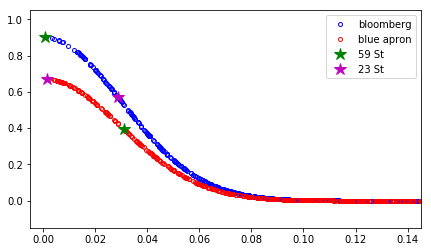

In [15]:
# As a check, plot the output of the smoothing function for a few tech sites #
techA, techB = 'bloomberg', 'blue apron'
wt_techA = df_merge[df_merge['Company_ID']==techA].sort_values('Wt_Tech',ascending=False)
wt_techB = df_merge[df_merge['Company_ID']==techB].sort_values('Wt_Tech',ascending=False)

xxA,yyA = wt_techA['Distance'], wt_techA['Wt_Tech']
xxB,yyB = wt_techB['Distance'], wt_techB['Wt_Tech']

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(xxA,yyA,'bo',xxB,yyB,'ro',markerfacecolor='None',markersize=4);
ax.set_xlim(-.005,.145); ax.set_ylim(-.15,1.05);

# Overlay on this plot two of the particular stations #
close2A = wt_techA.iloc[0]['Stop Name']  # find closest stop for each of the tech sites
close2B = wt_techB.iloc[0]['Stop Name']
idxA2B = wt_techA.index[wt_techA['Stop Name']==close2B][0] # index each to other tech site
idxB2A = wt_techB.index[wt_techB['Stop Name']==close2A][0] # take the first if duplicates

xxA_close,yyA_close = wt_techA.iloc[0]['Distance'], wt_techA.iloc[1]['Wt_Tech']
xxA_far,yyA_far = wt_techA.loc[idxA2B,'Distance'], wt_techA.loc[idxA2B,'Wt_Tech']
xxB_close,yyB_close = wt_techB.iloc[0]['Distance'], wt_techB.iloc[1]['Wt_Tech']
xxB_far,yyB_far = wt_techB.loc[idxB2A,'Distance'], wt_techB.loc[idxB2A,'Wt_Tech']

ax.plot(xxA_close,yyA_close,'go',marker='*',markersize=12);
ax.plot(xxA_far,yyA_far,'mo',marker='*',markersize=12);
ax.legend([techA,techB,close2A,close2B]);
ax.plot(xxB_close,yyB_close,'mo',marker='*',markersize=12);
ax.plot(xxB_far,yyB_far,'go',marker='*',markersize=12);

__Result__:  Hey, this is pretty cool.  Bloomberg (9000 employees) is a larger company, so its weighted distance profile is higher in amplitude than the one for Blue Apron (890 employees). Bloomberg's closest subway station is at 59th St (green star along blue trace), which checks out on Google Maps as only being 1 block away. On the other hand, Blue Apron's closest station is 23rd St (magenta star on red trace), which Google Maps shows as being on the same block. As expected, the distances from Blue Apron to the 59th St station and from Bloomberg to the 23rd St station are further, as these sites are on the order of .03 degrees (2 miles) apart.

(As an aside, at the time of the presentation I was using different coordinates for Blue Apron, but they were not associated with the main corporate office. I updated to the correct latitude and longitude values manually in the ```LAT_LON``` constant defined above, which changed the ranking of stations based on the final Benson Tech Score beginning with the 9th place. This speaks to the good habit of knowing your data well and keeping an eye out for inconsistent or inaccurate data.)

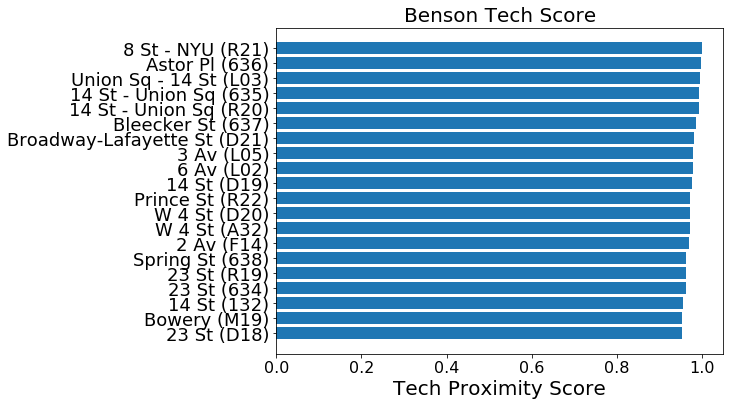

In [16]:
# Plot results for the top 20 stations as a horizontal bar chart #
# Unique station names are enforced here by combining the common station name with the
# unique but non-informative station code. (Presumably these represent different substations
# or entrances for the same station but far enough apart to consider them separate locations
# for the sake of the WTWY street volunteers.) If this isn't done, the bar plot function
# will skip redundant entries.
df_top20 = df_orig.iloc[:20]
stops = tuple(zip(list(df_top20['Stop Name']),list(df_top20['GTFS Stop ID'])));
stops = [f'{x} ({y})' for x,y in stops]  # new string combines station info
scores = list(df_top20['Benson Tech Score'])

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.barh(stops,scores);
plt.xticks(fontsize=16); plt.yticks(fontsize=18);
plt.xlabel('Tech Proximity Score', fontsize=20);
ax.invert_yaxis();
plt.title('Benson Tech Score',fontsize=20)

fig.subplots_adjust(left=0.28)           # this helps the labels fully appear in the .png
plt.savefig('Top20_Tech.png')

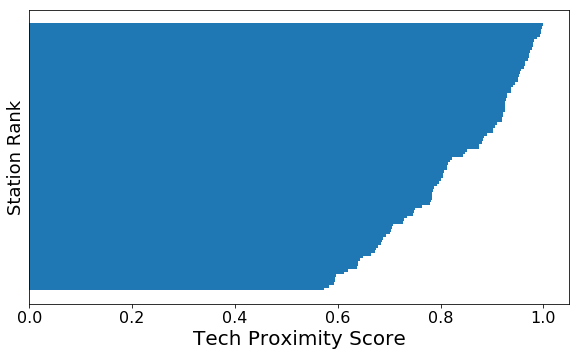

In [18]:
# Plot results for the the top 100 stations #
df_top100 = df_orig.iloc[:100]
stops100 = tuple(zip(list(df_top100['Stop Name']),list(df_top100['GTFS Stop ID'])));
stops100 = [f'{x} ({y})' for x,y in stops100]  # new string combines station info
scores100 = list(df_top100['Benson Tech Score'])

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.barh(stops100,scores100,height=1,linewidth=0);
plt.xticks(fontsize=16); plt.yticks([]);
plt.xlabel('Tech Proximity Score', fontsize=20);
plt.ylabel('Station Rank', fontsize=18);
ax.invert_yaxis();

fig.subplots_adjust(left=0.15,bottom=0.20)
plt.savefig('Top100_Tech.png')